## https://www.datahubbs.com/reinforce-with-pytorch/
## http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture14.pdf
## https://github.com/vitchyr/rlkit

In [1]:
import numpy as np 
#import matplotlib.pyplot as plt
from scipy.stats import norm
from math import *
import matplotlib.pyplot as plt

In [2]:
class BS_env:
    def __init__(self, S0,K,r,mu,sigma,T,nsim):
        self.S0 = S0
        self.K = K
        self.r = r
        self.mu = mu
        self.sigma = sigma
        self.T = T
        self.nsim = nsim
        self.dt = T/np.float(nsim)
        self.S = S0 #current stock
        self.t = 0 #current
        #self.B = 0 #brownian
        self.share = 0 #current share
        self.R = 0
        self.opt_price = self.bs_call()['callprice']
        self.bank = self.opt_price/(1+self.r) #only trick
        self.cost = 0

    def bs_call(self):
        S = self.S
        X = self.K
        T = self.T - self.t
        sigma =  self.sigma
        r = self.r
        d1 = (log(S/X)+(r+sigma*sigma/2.0)*T)/np.float(sigma*sqrt(T))   
        d2 = d1-sigma*sqrt(T)
        callprice = S*norm.cdf(d1)-X*exp(-r*T)*norm.cdf(d2)     #Calculate the Call price
        delta = norm.cdf(d1)                                    #Calculate the delta value
        return {'delta':delta, 'callprice':callprice}
    def reset(self):
        self.S = S0 #current stock
        self.t = 0 #current
        #self.B = 0 #brownian
        self.share = 0 #current share
        self.R = 0
        self.opt_price = self.bs_call()['callprice']
        self.bank = self.opt_price/(1+self.r) #only trick
        self.cost = 0
        return np.array([self.S,self.t])
    def step(self,action):
        self.cost = (action)*self.S 
        self.bank = self.bank*(1+self.r) - (action - self.share)*self.S
        self.share = action
        self.t = np.min([self.dt + self.t,1])
        
        self.R = -np.abs(self.bank + self.cost  - self.opt_price)
        
        self.S =self.S + self.S * self.mu * self.dt + self.S * self.sigma * np.sqrt(self.dt)*np.random.normal()


        self.opt_price = self.bs_call()['callprice']
        if (self.t == self.T): 
            done =1
        else:
            done=0
        return np.array([self.S,self.t]), self.R, done

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable
from torch.distributions.distribution import Distribution



In [12]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(Actor, self).__init__()
        self.num_outputs = num_outputs
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            #nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            #nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),

            nn.ReLU(),
 
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        #value = self.critic(x)
        probs = self.actor(x)
        #dist  = Categorical(probs)
        return probs
    
    def action(self, x):
        #value = self.critic(x)
        probs = self.actor(x)
        m = Categorical(probs)
        action = m.sample()
        log_probs = m.log_prob(action)
        return action.to(dtype=torch.float)/self.num_outputs, log_probs
        #z = probs.multinomial(1, replacement=True)
        #log_probs = Multinomial(probs= probs).log_prob(z)
        #return z.numpy()/self.num_outputs, log_probs

class Critic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(Critic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Linear(hidden_size, hidden_size),


             
            nn.Linear(hidden_size, hidden_size),
            
            nn.Linear(hidden_size, num_outputs),
            #nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        #probs = self.actor(x)
        #dist  = Categorical(probs)
        return value

In [13]:
num_inputs =2 #gia va time
num_action =10
num_val = 1
hidden_size = 50


ac = Actor(num_inputs, num_action, hidden_size)  
cri = Critic(num_inputs, num_val, hidden_size)  

optimizer_ac = torch.optim.Adam(ac.parameters(),lr=0.001)
optimizer_cri = torch.optim.Adam(cri.parameters(),lr=0.001)

loss_fn = torch.nn.MSELoss()




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

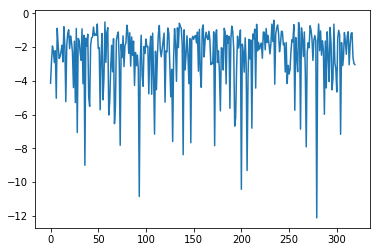

In [14]:
# Superparameters

MAX_EPISODE = 320
GAMMA = 0.99     # reward discount in TD error


### BS parameters
S0 = 100
K = 100

mu = 0.1
sigma = 0.1
T = 1
nsim =1100
r = 0.01/(1000/T)

ENV1 = BS_env(S0,K,r,mu,sigma,T,nsim)
l_tam = []
v_loss = []
a_loss = []
for i in range(MAX_EPISODE):
    print(i)
    s = ENV1.reset()
    states = []
    next_states = []
    rewards = []
    actions = []
    log_probs = []
    
    #complete = False
    critic_target = []
    for i in range(nsim):
        aaaa,lo = ac.action(torch.Tensor([[s]]))
        action = np.reshape(aaaa,1)
        #action = ENV1.bs_call()['delta']
        log_prob = lo.detach().numpy().item()
        s1, R, complete = ENV1.step(action)
        #print(action)
        #complete =1 target =0, dua target len day?
        states.append(s)
        next_states.append(s1)
        s = s1
        rewards.append(R.item())
        actions.append(action.item())
        log_probs.append(log_prob)
    SS = np.expand_dims(states, axis=1)
    Snext = np.expand_dims(next_states, axis=1)
    RR = np.expand_dims(rewards, axis=1)
    Llog_probs = np.expand_dims(log_probs, axis=1)
    #critic_target = RR+ GAMMA* cri(torch.Tensor(SS)).detach().numpy()
    critic_target = torch.Tensor(RR)+ GAMMA* cri.forward(torch.Tensor(Snext)).view(-1,1)
    critic_target[-1]=0  
        

    critic_loss = loss_fn(critic_target,cri.forward(torch.Tensor(SS)).view(-1,1))
    tdd = critic_target - cri.forward(torch.Tensor(SS)).view(-1,1)
    td = Variable(tdd, requires_grad = False).float() 
    td[-1] = 0
    log_p = Variable(torch.tensor(Llog_probs), requires_grad = True).float() 
    actor_loss = -(log_p*td).mean()
    
    #
    l_tam.append((np.asarray(rewards)).mean())
    v_loss.append(critic_loss.detach().numpy().item())
    a_loss.append(actor_loss.detach().numpy().item())
    #
    optimizer_cri.zero_grad
    critic_loss.backward()
    optimizer_cri.step()
    #l_tam.append(loss.data.numpy())
    optimizer_ac.zero_grad
    actor_loss.backward()
    optimizer_ac.step()
    
    
plt.plot(np.asarray(l_tam))

-2.5485279385422404

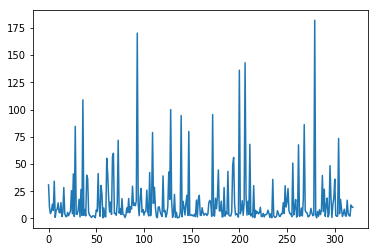

In [18]:
plt.plot(np.asarray(v_loss))
np.mean(np.asarray(l_tam))

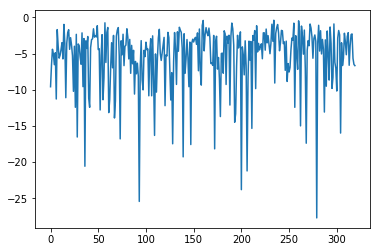

In [19]:
plt.plot(np.asarray(a_loss))

In [17]:
a_loss

[-9.580108642578125,
 -6.5607523918151855,
 -4.397561550140381,
 -5.062326431274414,
 -6.531904697418213,
 -4.882733345031738,
 -11.277308464050293,
 -1.677665114402771,
 -3.9843266010284424,
 -5.626873016357422,
 -5.221310615539551,
 -4.435894012451172,
 -3.489539384841919,
 -5.7355732917785645,
 -0.9607285261154175,
 -3.578761100769043,
 -11.095765113830566,
 -3.563086986541748,
 -2.075301170349121,
 -1.6942760944366455,
 -4.407820224761963,
 -2.796370267868042,
 -3.8180108070373535,
 -5.288190841674805,
 -10.213911056518555,
 -3.9780735969543457,
 -12.422435760498047,
 -2.3321170806884766,
 -16.531442642211914,
 -3.6652233600616455,
 -3.884098529815674,
 -5.431251049041748,
 -6.4677276611328125,
 -2.132855176925659,
 -9.56539249420166,
 -2.919222116470337,
 -20.57559585571289,
 -3.2347617149353027,
 -4.282411098480225,
 -2.6323907375335693,
 -11.176288604736328,
 -12.426623344421387,
 -4.164824962615967,
 -3.061290740966797,
 -2.9586551189422607,
 -1.5672376155853271,
 -2.7234904766